In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
pd.set_option('display.max_columns', 50)

## Load The Data

In [3]:
columns = ['Age', 'Sex', 'ChestPain', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


In [4]:
df_heart = pd.read_csv('heart.csv', names=columns, skiprows=1)

In [5]:
df_heart.head()

,Age,Sex,ChestPain,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
# Handle missing values
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_heart[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']] = imputer.fit_transform(df_heart[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']])


In [68]:
y = df_heart['HeartDisease']
X = df_heart.drop('HeartDisease', axis=1)
X.head()

,Age,Sex,ChestPain,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,Sex_Color,ChestPain_Color,RestingECG_Color
0,40.0,M,ATA,140.0,289.0,0,Normal,172.0,N,0.0,Up,blue,yellow,green
1,49.0,F,NAP,160.0,180.0,0,Normal,156.0,N,1.0,Flat,pink,orange,green
2,37.0,M,ATA,130.0,283.0,0,ST,98.0,N,0.0,Up,blue,yellow,orange
3,48.0,F,ASY,138.0,214.0,0,Normal,108.0,Y,1.5,Flat,pink,red,green
4,54.0,M,NAP,150.0,195.0,0,Normal,122.0,N,0.0,Up,blue,orange,green


In [8]:
X.shape

(918, 11)

In [69]:
X.columns

Index(['Age', 'Sex', 'ChestPain', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'Sex_Color', 'ChestPain_Color', 'RestingECG_Color'],
      dtype='object')

### Encode Non Numerical Feature
Assigns numbers for features that are not originally numbers

In [70]:
# Encode categorical variables
encoder = OneHotEncoder()
X_encoded = pd.concat([
    pd.DataFrame(encoder.fit_transform(X[['Sex']]).toarray(), columns=['Female', 'Male']),
    pd.DataFrame(encoder.fit_transform(X[['ChestPain']]).toarray(), columns=['ATA', 'ASY', 'NAP', 'TA']),
    pd.DataFrame(encoder.fit_transform(X[['RestingECG']]).toarray(), columns=['LVH', 'Normal', 'ST']),
    pd.DataFrame(encoder.fit_transform(X[['ExerciseAngina']]).toarray(), columns=['N', 'Y']),
    pd.DataFrame(encoder.fit_transform(X[['ST_Slope']]).toarray(), columns=['Down', 'Flat', 'Up']),
    X[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']],  # Retain these columns
], axis=1)

In [71]:
X_encoded.shape

(918, 20)

In [72]:
X_encoded.head()

,Female,Male,ATA,ASY,NAP,TA,LVH,Normal,ST,N,Y,Down,Flat,Up,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,40.0,140.0,289.0,0,172.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,49.0,160.0,180.0,0,156.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,37.0,130.0,283.0,0,98.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,48.0,138.0,214.0,0,108.0,1.5
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,54.0,150.0,195.0,0,122.0,0.0


In [73]:
X_encoded.columns

Index(['Female', 'Male', 'ATA', 'ASY', 'NAP', 'TA', 'LVH', 'Normal', 'ST', 'N',
       'Y', 'Down', 'Flat', 'Up', 'Age', 'RestingBP', 'Cholesterol',
       'FastingBS', 'MaxHR', 'Oldpeak'],
      dtype='object')

## Visualize the Data

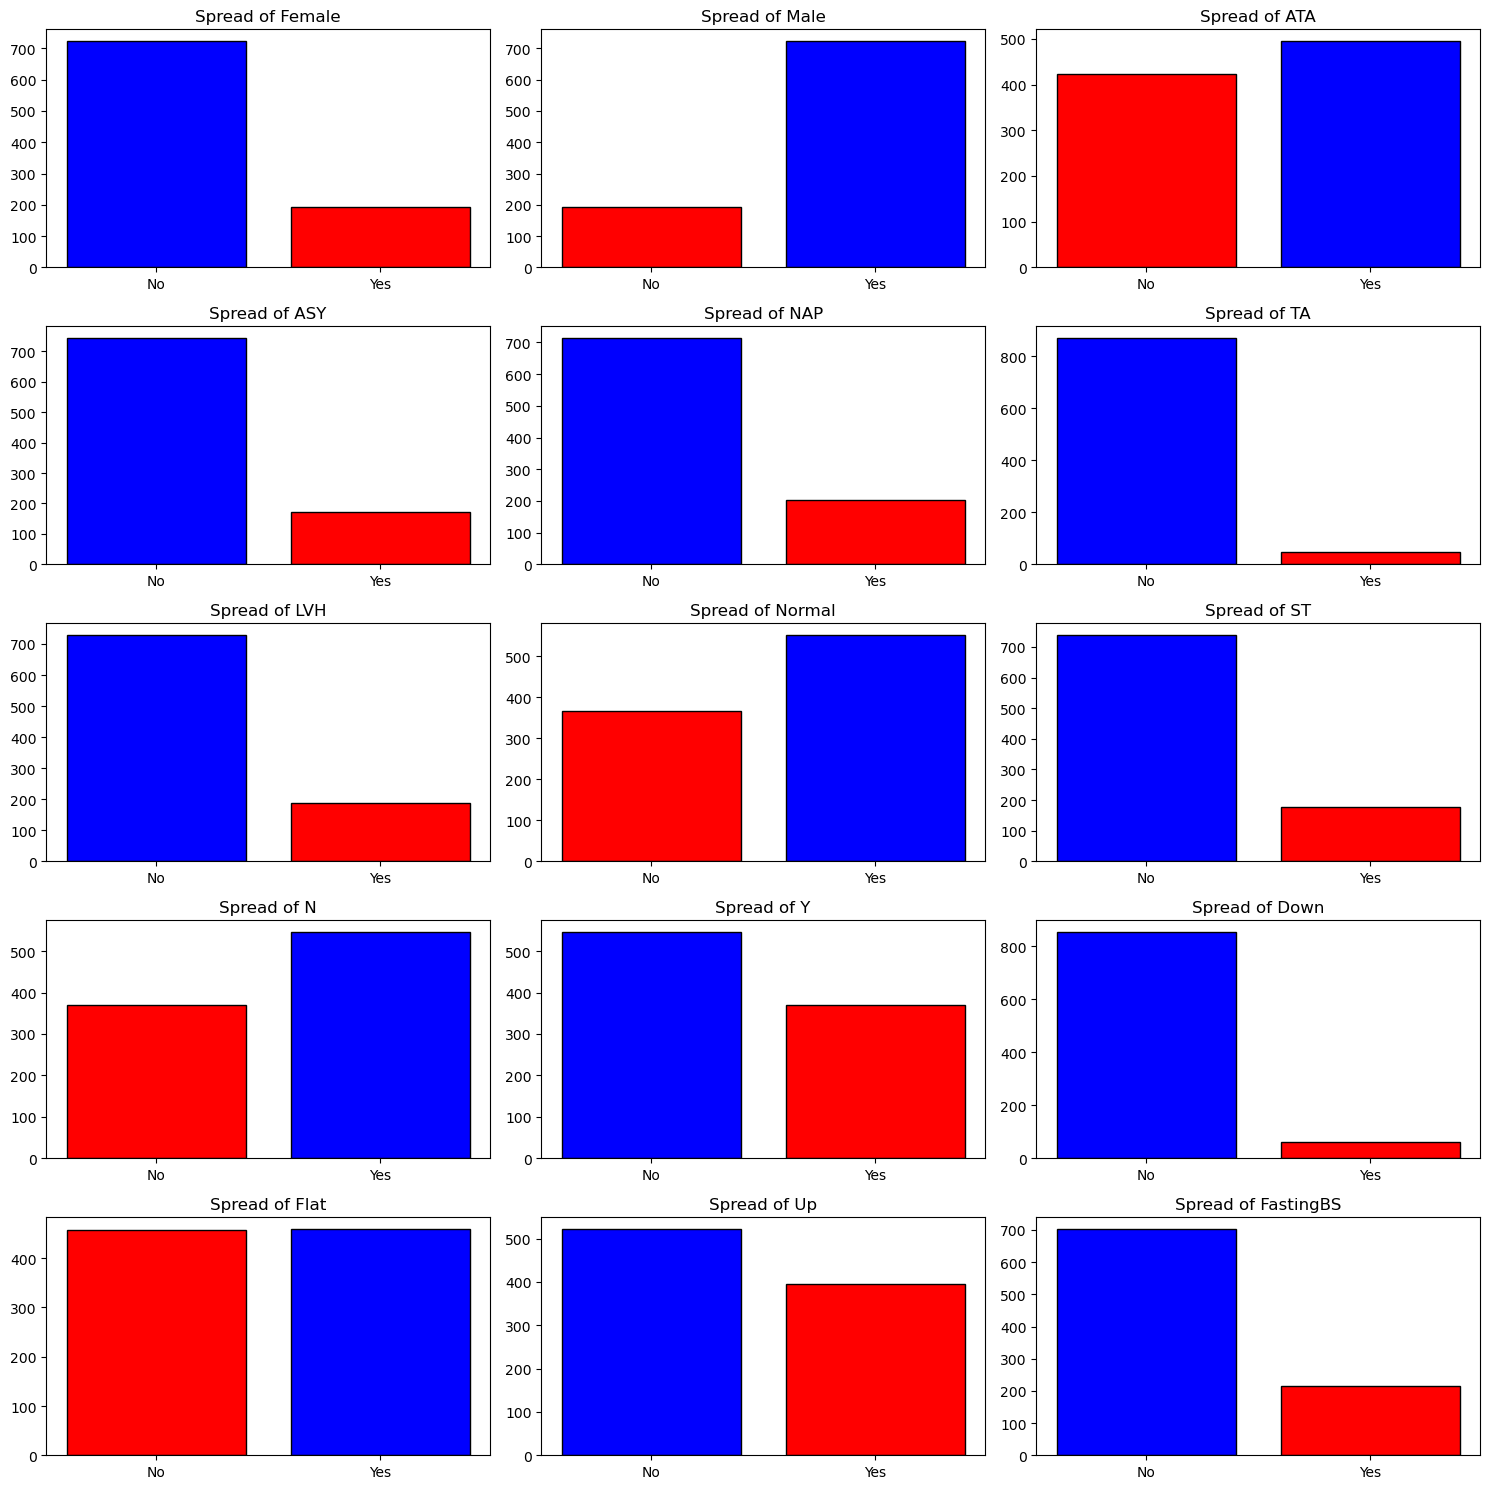

In [77]:
binary_features = ['Female', 'Male', 'ATA', 'ASY', 'NAP', 'TA', 'LVH', 'Normal', 'ST', 'N', 'Y', 'Down', 'Flat', 'Up', 'FastingBS']
fig, axs = plt.subplots(5, 3, figsize=(15, 15))
for i, feature in enumerate(binary_features):
    row = i // 3
    col = i % 3
    counts = X_encoded[feature].value_counts()
    axs[row, col].bar(counts.index, counts.values, color=['blue', 'red'], edgecolor='black')
    axs[row, col].set_title(f'Spread of {feature}')
    axs[row, col].set_xticks([0, 1])
    axs[row, col].set_xticklabels(['No', 'Yes'])
plt.tight_layout()
plt.show()

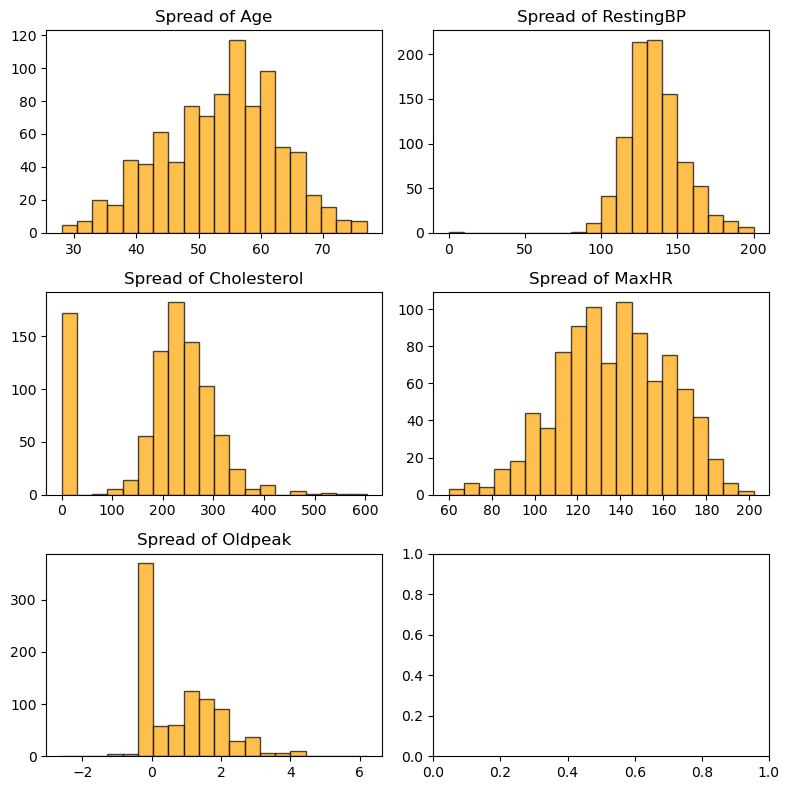

In [79]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
for i, feature in enumerate(numerical_features):
    row = i // 2
    col = i % 2
    axs[row, col].hist(X_encoded[feature], bins=20, color='orange', edgecolor='black', alpha=0.7)
    axs[row, col].set_title(f'Spread of {feature}')
plt.tight_layout()
plt.show()

### Scale numerical features
Standardizes each feature by subtracting the mean and dividing by the standard deviation, resulting in a mean of 0 and a standard deviation of 1 for each feature

In [80]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']]),
                        columns=['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'])


In [81]:
X_scaled.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,-1.433140,0.410909,0.825070,1.382928,-0.832432
1,-0.478484,1.491752,-0.171961,0.754157,0.105664
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432
3,-0.584556,0.302825,0.139040,-1.132156,0.574711
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432


In [82]:
X_encoded.drop(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'], axis=1, inplace=True)
X_encoded.head()

,Female,Male,ATA,ASY,NAP,TA,LVH,Normal,ST,N,Y,Down,Flat,Up,FastingBS
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


In [83]:
# Concatenate the encoded and scaled features
X_processed = pd.concat([X_encoded, X_scaled], axis=1)
X_processed.head()

,Female,Male,ATA,ASY,NAP,TA,LVH,Normal,ST,N,Y,Down,Flat,Up,FastingBS,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0,-1.433140,0.410909,0.825070,1.382928,-0.832432
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,-0.478484,1.491752,-0.171961,0.754157,0.105664
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,-1.751359,-0.129513,0.770188,-1.525138,-0.832432
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,-0.584556,0.302825,0.139040,-1.132156,0.574711
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.051881,0.951331,-0.034755,-0.581981,-0.832432


In [84]:
X_processed.shape

(918, 20)

### Remove Outliers
Remove 5% of outliers from the data with an isolation forest.

In [109]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.05)

outliers = iso_forest.fit_predict(X_processed)
X_filtered = X_processed[outliers == 1]
y_filtered = y[outliers == 1]

In [110]:
X_filtered.shape

(872, 20)

In [111]:
X_filtered.columns

Index(['Female', 'Male', 'ATA', 'ASY', 'NAP', 'TA', 'LVH', 'Normal', 'ST', 'N',
       'Y', 'Down', 'Flat', 'Up', 'FastingBS', 'Age', 'RestingBP',
       'Cholesterol', 'MaxHR', 'Oldpeak'],
      dtype='object')

In [112]:
y_filtered.shape

(872,)

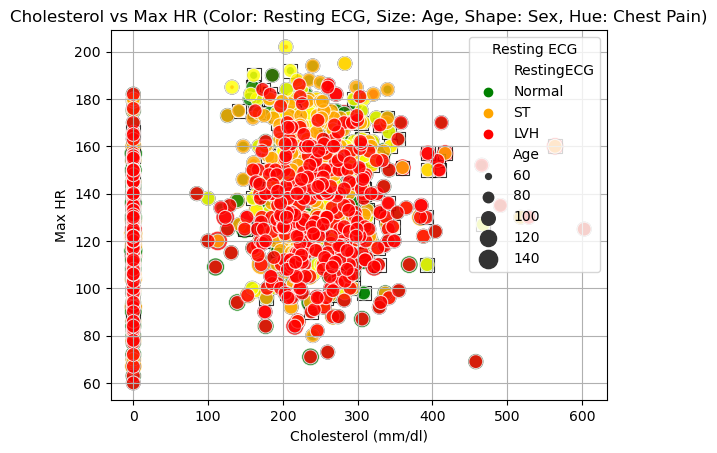

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palette for categorical variables
palette = {'M': 'blue', 'F': 'pink'}
chest_pain_palette = {'TA': 'green', 'ATA': 'yellow', 'NAP': 'orange', 'ASY': 'red'}
resting_ecg_palette = {'Normal': 'green', 'ST': 'orange', 'LVH': 'red'}

# Map categorical variables to colors
df_heart['Sex_Color'] = df_heart['Sex'].map(palette)
df_heart['ChestPain_Color'] = df_heart['ChestPain'].map(chest_pain_palette)
df_heart['RestingECG_Color'] = df_heart['RestingECG'].map(resting_ecg_palette)

# Define point sizes based on Age
sizes = df_heart['Age'] * 2

# Plot
sns.scatterplot(x='Cholesterol', y='MaxHR', hue='RestingECG', palette=resting_ecg_palette, size=sizes, sizes=(10, 200), data=df_heart, legend='brief', alpha=0.8)

# Customize legend
plt.legend(title='Resting ECG')

# Add Sex as shape marker
markers = {'M': 'o', 'F': 's'}
for category, marker in markers.items():
    sns.scatterplot(x='Cholesterol', y='MaxHR', color='none', style='Sex', markers={category: marker}, data=df_heart[df_heart['Sex'] == category], legend=False, edgecolor='black', s=100, alpha=0.8)

# Add ChestPain as hue
for category, color in chest_pain_palette.items():
    sns.scatterplot(x='Cholesterol', y='MaxHR', color='none', hue='ChestPain', palette={category: color}, data=df_heart[df_heart['ChestPain'] == category], legend=False, s=100, alpha=0.8)

# Add labels and title
plt.xlabel('Cholesterol (mm/dl)')
plt.ylabel('Max HR')
plt.title('Cholesterol vs Max HR (Color: Resting ECG, Size: Age, Shape: Sex, Hue: Chest Pain)')
plt.grid(True)
plt.show()

### Create the Train/Test split

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)



In [115]:
X_train.shape

(697, 20)

In [116]:
y_train.shape

(697,)

## SVM Classification

In [117]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
#default is rbf model

SVC()

In [118]:
y_pred_svc = svm_model.predict(X_test)
accuracy_score(y_test, y_pred_svc)

0.8571428571428571

In [119]:
print(metrics.classification_report(y_pred_svc, y_test))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        73
           1       0.92      0.82      0.87       102

    accuracy                           0.86       175
   macro avg       0.85      0.86      0.86       175
weighted avg       0.87      0.86      0.86       175



Text(113.9222222222222, 0.5, 'predicted label')

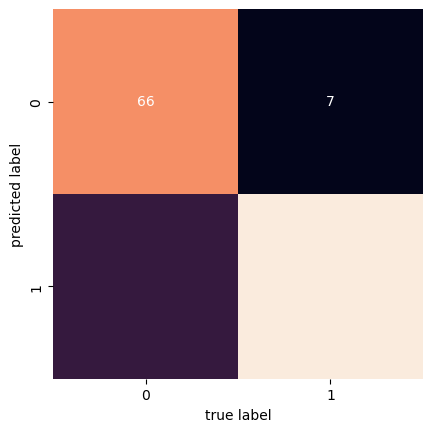

In [120]:
mat = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

# SVM Classification: Linear

In [121]:
svm_model_linear = SVC(kernel='linear')
svm_model_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [122]:
y_pred_svc_linear = svm_model_linear.predict(X_test)

In [123]:
accuracy_score(y_test, y_pred_svc_linear)

0.8571428571428571

In [124]:
print(metrics.classification_report(y_pred_svc_linear, y_test))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84        77
           1       0.90      0.84      0.87        98

    accuracy                           0.86       175
   macro avg       0.86      0.86      0.86       175
weighted avg       0.86      0.86      0.86       175



Text(113.9222222222222, 0.5, 'predicted label')

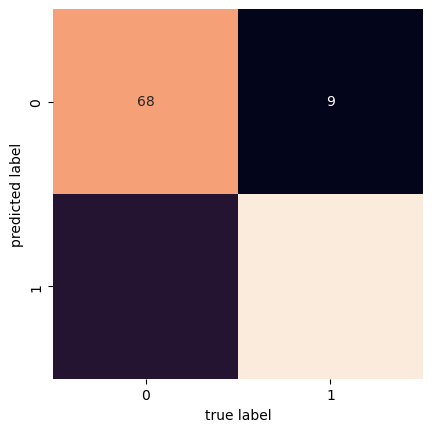

In [125]:
mat = confusion_matrix(y_test, y_pred_svc_linear)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

# SVM Classification: Polynomial (Quadratic)

In [126]:
svm_poly = SVC(kernel='poly', degree=2)
svm_poly.fit(X_train, y_train)

SVC(degree=2, kernel='poly')

In [127]:
y_pred_svc_poly = svm_poly.predict(X_test)

In [128]:
accuracy_score(y_test, y_pred_svc_poly)

0.8571428571428571

In [129]:
print(metrics.classification_report(y_pred_svc_poly, y_test))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        75
           1       0.91      0.83      0.87       100

    accuracy                           0.86       175
   macro avg       0.85      0.86      0.86       175
weighted avg       0.86      0.86      0.86       175



Text(113.9222222222222, 0.5, 'predicted label')

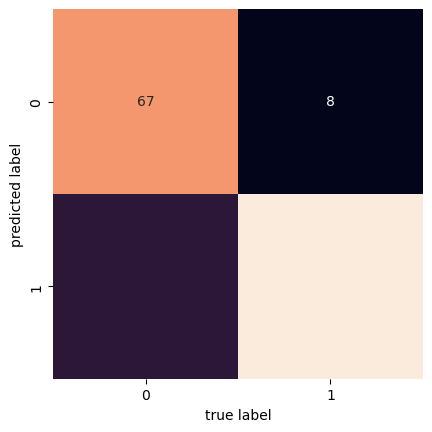

In [130]:
mat = confusion_matrix(y_test, y_pred_svc_poly)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

# Random Forest Classification

In [131]:
from sklearn.ensemble import RandomForestClassifier

In [132]:
rfc = RandomForestClassifier(n_estimators=1000, random_state=0)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
#visualize_classifier(rfc, X_, y_train)

In [133]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
print(metrics.classification_report(y_pred_rfc, y_test))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        71
           1       0.93      0.82      0.87       104

    accuracy                           0.86       175
   macro avg       0.85      0.87      0.86       175
weighted avg       0.87      0.86      0.86       175



Text(113.9222222222222, 0.5, 'predicted label')

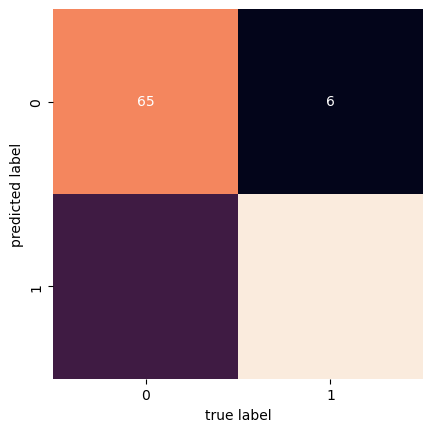

In [134]:
mat = confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

## Decision Tree Classification

In [135]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [136]:
y_pred_dt = dt.predict(X_test)
accuracy_score(y_test, y_pred_dt)

0.8228571428571428

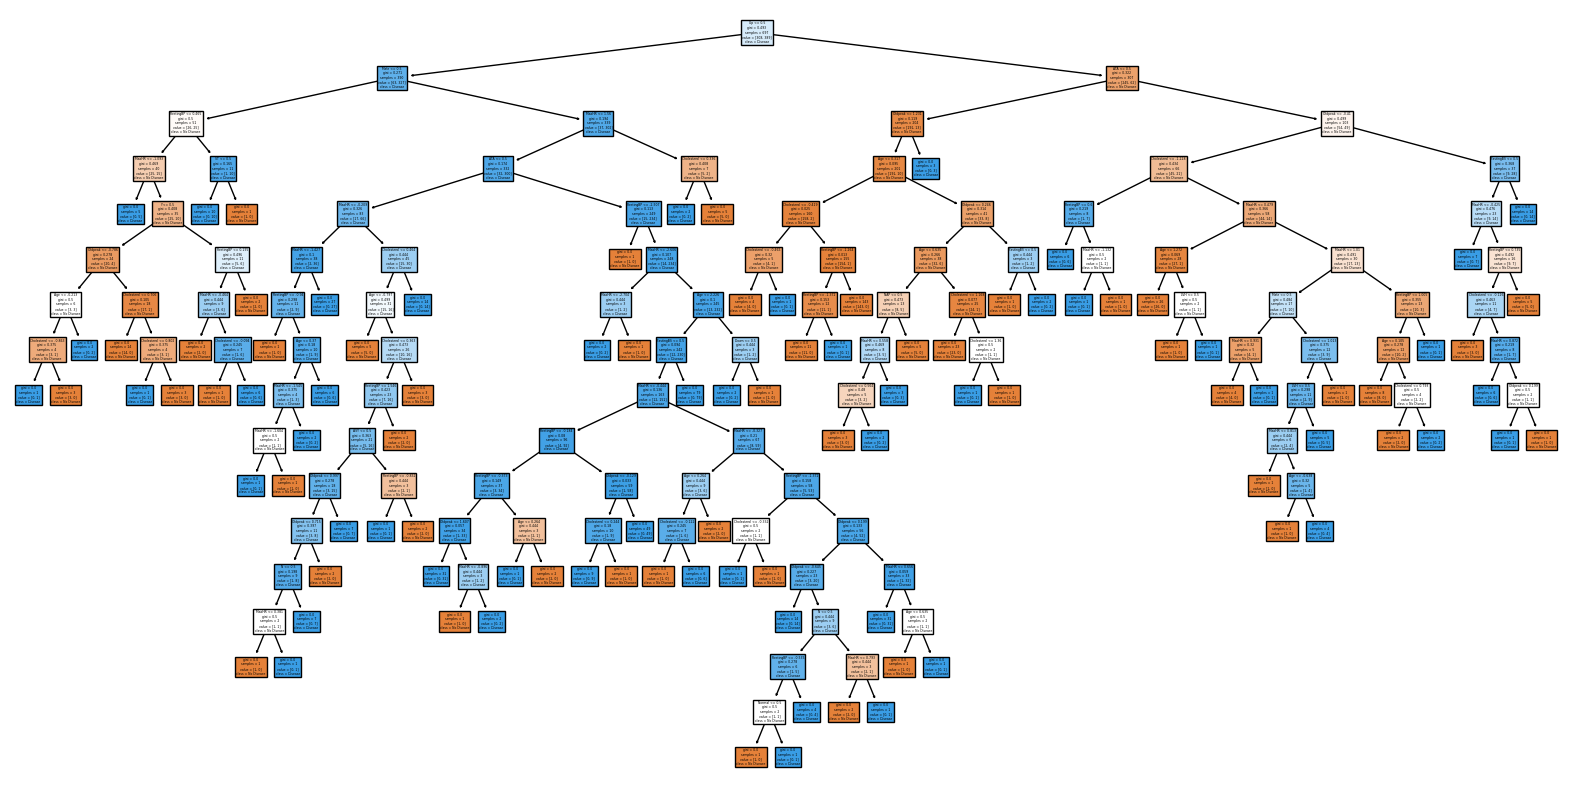

In [137]:
# Display the decision tree
feat_names = X_train.columns.tolist()
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=feat_names, class_names=['No Disease', 'Disease'])
plt.show()

In [138]:
dt.tree_.node_count

197

## Gradient Boosting Classification 

In [139]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
accuracy = gb.score(X_test, y_test)
print(accuracy)

0.8514285714285714
